In [1]:
# Import libraries
import numpy as np
import pandas as pd
import scipy
import scipy.stats as scs
from scipy import special
from scipy.stats import norm 
from pathlib import Path
import math 


Nout = 100000  # number of out-of-sample scenarios
Nin = 5000     # number of in-sample scenarios
Ns = 5         # number of idiosyncratic scenarios for each systemic

C = 8          # number of credit states

# Read and parse instrument data
instr_data = np.array(pd.read_csv('instrum_data.csv', header=None))
instr_id = instr_data[:, 0]     # ID
driver = instr_data[:, 1]       # credit driver
beta = instr_data[:, 2]         # beta (sensitivity to credit driver)
recov_rate = instr_data[:, 3]   # expected recovery rate
value = instr_data[:, 4]        # value
prob = instr_data[:, 5:(5 + C)] # credit-state migration probabilities (default to AAA)
exposure = instr_data[:, 5 + C:5 + 2 * C]  # credit-state migration exposures (default to AAA)
retn = instr_data[:, 5 + 2 * C] # market returns

K = instr_data.shape[0]         # number of CPs

# Read matrix of correlations for credit drivers
rho = np.array(pd.read_csv('credit_driver_corr.csv', sep='\t', header=None))
# Cholesky decomp of rho (for generating correlated Normal random numbers)
sqrt_rho = np.linalg.cholesky(rho)

print('======= Credit Risk Model with Credit-State Migrations =======')
print('============== Monte Carlo Scenario Generation ===============')
print(' ')
print(' ')
print(' Number of out-of-sample Monte Carlo scenarios = ' + str(Nout))
print(' Number of in-sample Monte Carlo scenarios = ' + str(Nin))
print(' Number of counterparties = ' + str(K))
print(' ')

# Find credit-state for each counterparty
# 8 = AAA, 7 = AA, 6 = A, 5 = BBB, 4 = BB, 3 = B, 2 = CCC, 1 = default
CS = np.argmax(prob, axis=1) + 1

# Account for default recoveries
exposure[:, 0] = (1 - recov_rate) * exposure[:, 0]

# Compute credit-state boundaries
CS_Bdry = scipy.special.ndtri((np.cumsum(prob[:, 0:C - 1], 1)))

# -------- Insert your code here -------- #
filename_save_out = 'scenarios_out'
Ndriver = len(rho)

if Path(filename_save_out+'.npz').is_file():
    Losses_out = scipy.sparse.load_npz(filename_save_out + '.npz')
    
else:
    # Generating Scenarios

    # -------- Insert your code here -------- #
    # Define systemic risk credit driver credit risk driver 
    y = np.zeros((Nout, Ndriver))
    # Define creditworthiness index 
    w = np.zeros((Nout, K))
    # Define losses out
    Losses_out = np.zeros((Nout, K))
    
    for s in range(1, Nout + 1):
        # -------- Insert your code here -------- #
        # Random number generator 
        normal_random = np.random.normal(0,1,(Ndriver,1))
        y[s-1] = np.dot(sqrt_rho, normal_random).T
        z = np.random.normal(0,1,(K,1))
        
        # Compute each counterparty's w 
        for k in range(K):
            credit_driver = driver[k]
            w[s-1,k] = beta[k]*y[s-1,int(credit_driver)-1] + math.sqrt(1-beta[k]**2)*z[k]
            credit_level = np.sort(np.append(w[s-1,k], CS_Bdry[k,:]))
            credit_index = np.argwhere(credit_level == w[s-1,k])
            # Calculated out-of-sample losses (100000 x 100)
            Losses_out[s-1,k] = exposure[k, credit_index[0][0]]
    # Losses_out (sparse matrix)
    Losses_out = scipy.sparse.csr_matrix(Losses_out)
    scipy.sparse.save_npz(filename_save_out + '.npz', Losses_out) 

======= Credit Risk Model with Credit-State Migrations =======
============== Monte Carlo Scenario Generation ===============
 
 
 Number of out-of-sample Monte Carlo scenarios = 100000
 Number of in-sample Monte Carlo scenarios = 5000
 Number of counterparties = 100
 


In [2]:
# Normal approximation computed from out-of-sample scenarios
mu_l = np.mean(Losses_out, axis=0).reshape((K))
var_l = np.cov(Losses_out.toarray(), rowvar=False) # Losses_out as a sparse matrix

# Compute portfolio weights
portf_v = sum(value)  # portfolio value
w0 = []
w0.append(value / portf_v)   # asset weights (portfolio 1)
w0.append(np.ones((K)) / K)  # asset weights (portfolio 2)
x0 = []
x0.append((portf_v / value) * w0[0])  # asset units (portfolio 1)
x0.append((portf_v / value) * w0[1])  # asset units (portfolio 2)

# Quantile levels (99%, 99.9%)
alphas = np.array([0.99, 0.999])

VaRout = np.zeros((2, alphas.size))
VaRinN = np.zeros((2, alphas.size))
CVaRout = np.zeros((2, alphas.size))
CVaRinN = np.zeros((2, alphas.size))

# Compute and sort portfolio value loss 
port_loss = []
port_loss.append(np.sort(Losses_out*x0[0]))
port_loss.append(np.sort(Losses_out*x0[1]))

for portN in range(2):
    # Compute VaR and CVaR
    for q in range(alphas.size):
        alf = alphas[q]
        # -------- Insert your code here -------- #

        VaRout[portN, q] = port_loss[portN][int(math.ceil(Nout*alf))-1]
        VaRinN[portN, q] = np.mean(port_loss[portN]) + scs.norm.ppf(alf) * np.std(port_loss[portN])
        CVaRout[portN, q] = (1/(Nout*(1-alf))) * ((math.ceil(Nout*alf)-Nout*alf)*VaRout[portN, q] + sum(port_loss[portN][int(math.ceil(Nout*alf)):]))
        CVaRinN[portN, q] = np.mean(port_loss[portN]) + (scs.norm.pdf(scs.norm.ppf(alf)) / (1-alf)) * np.std(port_loss[portN])

In [3]:
# Perform 100 trials
N_trials = 100
port_loss_inMC1 = np.zeros((N_trials, 2, Nin))
port_loss_inMC2 = np.zeros((N_trials, 2, Nin))

VaRinMC1 = {}
VaRinMC2 = {}
VaRinN1 = {}
VaRinN2 = {}
CVaRinMC1 = {}
CVaRinMC2 = {}
CVaRinN1 = {}
CVaRinN2 = {}

for portN in range(2):
    for q in range(alphas.size):
        VaRinMC1[portN, q] = np.zeros(N_trials)
        VaRinMC2[portN, q] = np.zeros(N_trials)
        VaRinN1[portN, q] = np.zeros(N_trials)
        VaRinN2[portN, q] = np.zeros(N_trials)
        CVaRinMC1[portN, q] = np.zeros(N_trials)
        CVaRinMC2[portN, q] = np.zeros(N_trials)
        CVaRinN1[portN, q] = np.zeros(N_trials)
        CVaRinN2[portN, q] = np.zeros(N_trials)

for tr in range(1, N_trials + 1):
    # Monte Carlo approximation 1

    # -------- Insert your code here -------- #
    N_MC1 = np.int(np.ceil(Nin / Ns))
    w_MC1 = np.zeros((N_MC1, Ns, K))
    y_MC1 = np.zeros((N_MC1, Ndriver))
    Losses_MC1 = np.zeros((N_MC1, Ns, K))
    Losses_inMC1 = np.zeros((Nin, K)) # convert to matrix 
    i = 0
    for s in range(1, np.int(np.ceil(Nin / Ns) + 1)): # systemic scenarios
        # -------- Insert your code here -------- #
        normal_random = np.random.normal(0,1,(Ndriver,1))
        y_MC1[s-1] = np.dot(sqrt_rho, normal_random).T
        
        for si in range(1, Ns + 1): # idiosyncratic scenarios for each systemic
            # -------- Insert your code here -------- #
            z_MC1 = np.random.normal(0,1,(K,1))
            for k in range(K): 
                credit_driver = driver[k]
                w_MC1[s-1,si-1,k] = beta[k]*y_MC1[s-1,int(credit_driver)-1] + math.sqrt(1-beta[k]**2)*z_MC1[k]
                credit_level = np.sort(np.append(w_MC1[s-1,si-1,k], CS_Bdry[k,:]))
                credit_index = np.argwhere(credit_level == w_MC1[s-1,si-1,k])
                # Calculated in-sample losses (1000 x 5 x 100)
                Losses_MC1[s-1,si-1,k] = exposure[k, credit_index[0][0]]   
            # Calculate losses for MC1 approximation (5000 x 100)
            # Losses_inMC1
            Losses_inMC1[i] = Losses_MC1[s-1,si-1]
            i = i + 1
    
    # Monte Carlo approximation 2

    # -------- Insert your code here -------- #
    w_MC2 = np.zeros((Nin,K))
    y_MC2 = np.zeros((Nin,Ndriver))
    Losses_inMC2 = np.zeros((Nin,K))

    for s in range(1, Nin + 1): # systemic scenarios (1 idiosyncratic scenario for each systemic)
        # -------- Insert your code here -------- #
        normal_random = np.random.normal(0,1,(Ndriver,1))
        y_MC2[s-1] = np.dot(sqrt_rho, normal_random).T
        z_MC2 = np.random.normal(0,1,(K,1))
        for k in range(K): 
            credit_driver = driver[k]
            w_MC2[s-1,k] = beta[k]*y_MC2[s-1,int(credit_driver)-1] + math.sqrt(1-beta[k]**2)*z_MC2[k]
            credit_level = np.sort(np.append(w_MC2[s-1,k], CS_Bdry[k,:]))
            credit_index = np.argwhere(credit_level == w_MC2[s-1,k])
            # Calculated losses for MC2 approximation (5000 x 100)
            # Losses_inMC2
            Losses_inMC2[s-1,k] = exposure[k, credit_index[0][0]]
    
    # Compute VaR and CVaR

    for portN in range(2):
        for q in range(alphas.size):
            alf = alphas[q]
            # -------- Insert your code here -------- #
            # Compute portfolio loss
            port_loss_inMC1[tr-1,portN] = np.sort(np.dot(Losses_inMC1,x0[portN]))
            port_loss_inMC2[tr-1,portN] = np.sort(np.dot(Losses_inMC2,x0[portN]))
            mu_MC1 = np.mean(Losses_inMC1, axis=0).reshape((K))
            var_MC1 = np.cov(Losses_inMC1, rowvar=False)
            mu_MC2 = np.mean(Losses_inMC2, axis=0).reshape((K))
            var_MC2 = np.cov(Losses_inMC2, rowvar=False)
            # Compute portfolio mean loss mu_p_MC1 and portfolio standard deviation of losses sigma_p_MC1
            # Compute portfolio mean loss mu_p_MC2 and portfolio standard deviation of losses sigma_p_MC2
            # Compute VaR and CVaR for the current trial
            mu_p_MC1 = np.dot(mu_MC1,x0[portN])
            sigma_p_MC1 = np.std(port_loss_inMC1[tr-1,portN])
            mu_p_MC2 = np.dot(mu_MC2,x0[portN])
            sigma_p_MC2 = np.std(port_loss_inMC2[tr-1,portN])
            VaRinMC1[portN, q][tr - 1] = port_loss_inMC1[tr-1,portN][int(math.ceil(Nin*alf))-1]
            VaRinMC2[portN, q][tr - 1] = port_loss_inMC2[tr-1,portN][int(math.ceil(Nin*alf))-1]
            VaRinN1[portN, q][tr - 1] =  np.mean(port_loss_inMC1[tr-1,portN]) + scs.norm.ppf(alf) * np.std(port_loss_inMC1[tr-1,portN])
            VaRinN2[portN, q][tr - 1] =  np.mean(port_loss_inMC2[tr-1,portN]) + scs.norm.ppf(alf) * np.std(port_loss_inMC2[tr-1,portN])
            CVaRinMC1[portN, q][tr - 1] = (1/(Nin*(1-alf))) * ((math.ceil(Nin*alf)-Nin*alf)*VaRinMC1[portN, q][tr - 1] + sum(port_loss_inMC1[tr-1,portN][int(math.ceil(Nin*alf)):]))
            CVaRinMC2[portN, q][tr - 1] = (1/(Nin*(1-alf))) * ((math.ceil(Nin*alf)-Nin*alf)*VaRinMC2[portN, q][tr - 1] + sum(port_loss_inMC2[tr-1,portN][int(math.ceil(Nin*alf)):]))
            CVaRinN1[portN, q][tr - 1] =  np.mean(port_loss_inMC1[tr-1,portN]) + (scs.norm.pdf(scs.norm.ppf(alf)) / (1-alf)) * np.std(port_loss_inMC1[tr-1,portN])
            CVaRinN2[portN, q][tr - 1] =  np.mean(port_loss_inMC2[tr-1,portN]) + (scs.norm.pdf(scs.norm.ppf(alf)) / (1-alf)) * np.std(port_loss_inMC2[tr-1,portN])         

In [4]:
# Display VaR and CVaR

for portN in range(2):
    print('\nPortfolio {}:\n'.format(portN + 1))
    for q in range(alphas.size):
        alf = alphas[q]
        print('Out-of-sample: VaR %4.1f%% = $%6.2f, CVaR %4.1f%% = $%6.2f' % (
        100 * alf, VaRout[portN, q], 100 * alf, CVaRout[portN, q]))
        print('In-sample MC1: VaR %4.1f%% = $%6.2f, CVaR %4.1f%% = $%6.2f' % (
        100 * alf, np.mean(VaRinMC1[portN, q]), 100 * alf, np.mean(CVaRinMC1[portN, q])))
        print('In-sample MC2: VaR %4.1f%% = $%6.2f, CVaR %4.1f%% = $%6.2f' % (
        100 * alf, np.mean(VaRinMC2[portN, q]), 100 * alf, np.mean(CVaRinMC2[portN, q])))
        print('In-sample No: VaR %4.1f%% = $%6.2f, CVaR %4.1f%% = $%6.2f' % (
        100 * alf, VaRinN[portN, q], 100 * alf, CVaRinN[portN, q]))
        print('In-sample N1: VaR %4.1f%% = $%6.2f, CVaR %4.1f%% = $%6.2f' % (
        100 * alf, np.mean(VaRinN1[portN, q]), 100 * alf, np.mean(CVaRinN1[portN, q])))
        print('In-sample N2: VaR %4.1f%% = $%6.2f, CVaR %4.1f%% = $%6.2f\n' % (
        100 * alf, np.mean(VaRinN2[portN, q]), 100 * alf, np.mean(CVaRinN2[portN, q])))


Portfolio 1:

Out-of-sample: VaR 99.0% = $37499419.18, CVaR 99.0% = $44928346.33
In-sample MC1: VaR 99.0% = $37054678.08, CVaR 99.0% = $44486776.29
In-sample MC2: VaR 99.0% = $37155630.35, CVaR 99.0% = $44654402.43
In-sample No: VaR 99.0% = $26399876.93, CVaR 99.0% = $29307534.44
In-sample N1: VaR 99.0% = $26197574.18, CVaR 99.0% = $29085746.03
In-sample N2: VaR 99.0% = $26218152.77, CVaR 99.0% = $29110307.35

Out-of-sample: VaR 99.9% = $54955511.48, CVaR 99.9% = $63101481.08
In-sample MC1: VaR 99.9% = $53390451.99, CVaR 99.9% = $60435096.45
In-sample MC2: VaR 99.9% = $53641899.50, CVaR 99.9% = $61889999.43
In-sample No: VaR 99.9% = $32954420.72, CVaR 99.9% = $35330010.94
In-sample N1: VaR 99.9% = $32708192.71, CVaR 99.9% = $35067862.91
In-sample N2: VaR 99.9% = $32737749.30, CVaR 99.9% = $35100673.44


Portfolio 2:

Out-of-sample: VaR 99.0% = $27589006.39, CVaR 99.0% = $33719667.73
In-sample MC1: VaR 99.0% = $27192020.34, CVaR 99.0% = $32987042.15
In-sample MC2: VaR 99.0% = $27407444

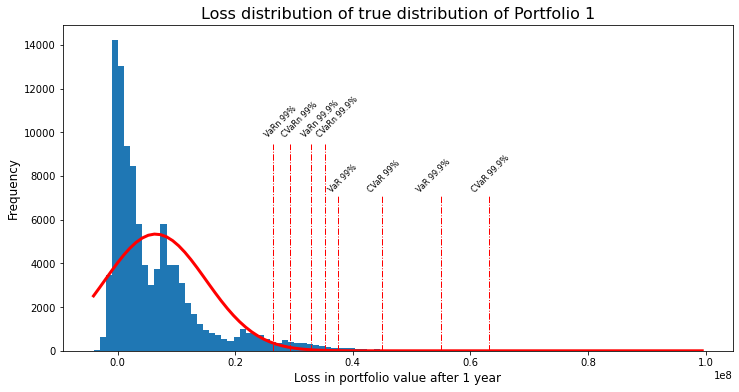

In [5]:
# Plot results
import matplotlib.pyplot as plt 
# Figure (1):
# -------- Insert your code here -------- #
# Out-of-sample loss distribution 
fig = plt.figure(figsize=(12,6))
frequencyCounts, binLocations, patches = plt.hist(port_loss[0], bins=100)
normf = (1 / (np.std(port_loss[0])*math.sqrt(2*math.pi))) * np.exp(-0.5 * ((binLocations - np.mean(port_loss[0]))/np.std(port_loss[0]))**2)
normf = normf * sum(frequencyCounts) / sum(normf)
plt.plot(binLocations, normf, color='r', linewidth = 3.0)
plt.plot([VaRout[0,0],VaRout[0,0]],[0,max(frequencyCounts)/2],color='r',linewidth=1,linestyle='-.')
plt.text(0.95*VaRout[0,0], max(frequencyCounts)/1.95, 'VaR 99%',fontsize=8, rotation=45)
plt.plot([VaRout[0,1],VaRout[0,1]],[0,max(frequencyCounts)/2],color='r',linewidth=1,linestyle='-.')
plt.text(0.92*VaRout[0,1], max(frequencyCounts)/1.95, 'VaR 99.9%',fontsize=8, rotation=45)
plt.plot([CVaRout[0,0],CVaRout[0,0]],[0,max(frequencyCounts)/2],color='r',linewidth=1,linestyle='-.')
plt.text(0.94*CVaRout[0,0], max(frequencyCounts)/1.95, 'CVaR 99%',fontsize=8, rotation=45)
plt.plot([CVaRout[0,1],CVaRout[0,1]],[0,max(frequencyCounts)/2],color='r',linewidth=1,linestyle='-.')
plt.text(0.95*CVaRout[0,1], max(frequencyCounts)/1.95, 'CVaR 99.9%',fontsize=8, rotation=45)

plt.plot([VaRinN[0,0],VaRinN[0,0]],[0,max(frequencyCounts)/1.5],color='r',linewidth=1,linestyle='-.')
plt.text(0.94*VaRinN[0,0], max(frequencyCounts)/1.45, 'VaRn 99%',fontsize=8, rotation=45)
plt.plot([VaRinN[0,1],VaRinN[0,1]],[0,max(frequencyCounts)/1.5],color='r',linewidth=1,linestyle='-.')
plt.text(0.94*VaRinN[0,1], max(frequencyCounts)/1.45, 'VaRn 99.9%',fontsize=8, rotation=45)
plt.plot([CVaRinN[0,0],CVaRinN[0,0]],[0,max(frequencyCounts)/1.5],color='r',linewidth=1,linestyle='-.')
plt.text(0.94*CVaRinN[0,0], max(frequencyCounts)/1.45, 'CVaRn 99%',fontsize=8, rotation=45)
plt.plot([CVaRinN[0,1],CVaRinN[0,1]],[0,max(frequencyCounts)/1.5],color='r',linewidth=1,linestyle='-.')
plt.text(0.95*CVaRinN[0,1], max(frequencyCounts)/1.45, 'CVaRn 99.9%',fontsize=8, rotation=45)
plt.xlabel('Loss in portfolio value after 1 year',fontsize=12)
plt.ylabel('Frequency',fontsize=12)
plt.title('Loss distribution of true distribution of Portfolio 1',fontsize=16)
plt.show()


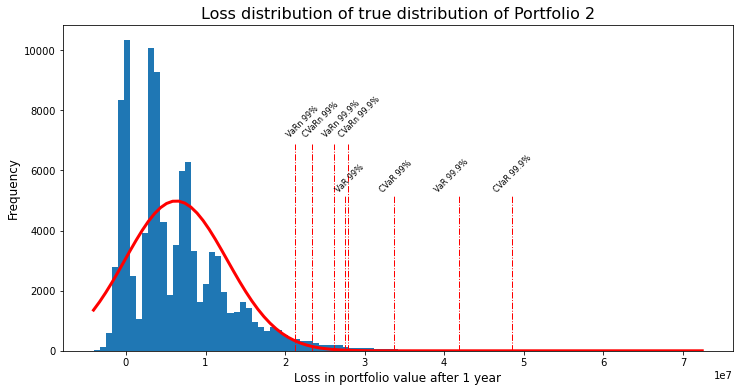

In [6]:
# Figure (2):
# -------- Insert your code here -------- #
fig = plt.figure(figsize=(12,6))
frequencyCounts, binLocations, patches = plt.hist(port_loss[1], bins=100)
normf = (1 / (np.std(port_loss[1])*math.sqrt(2*math.pi))) * np.exp(-0.5 * ((binLocations - np.mean(port_loss[1]))/np.std(port_loss[1]))**2)
normf = normf * sum(frequencyCounts) / sum(normf)
plt.plot(binLocations, normf, color='r', linewidth = 3.0)
plt.plot([VaRout[1,0],VaRout[1,0]],[0,max(frequencyCounts)/2],color='r',linewidth=1,linestyle='-.')
plt.text(0.95*VaRout[1,0], max(frequencyCounts)/1.95, 'VaR 99%',fontsize=8, rotation=45)
plt.plot([VaRout[1,1],VaRout[1,1]],[0,max(frequencyCounts)/2],color='r',linewidth=1,linestyle='-.')
plt.text(0.92*VaRout[1,1], max(frequencyCounts)/1.95, 'VaR 99.9%',fontsize=8, rotation=45)
plt.plot([CVaRout[1,0],CVaRout[1,0]],[0,max(frequencyCounts)/2],color='r',linewidth=1,linestyle='-.')
plt.text(0.94*CVaRout[1,0], max(frequencyCounts)/1.95, 'CVaR 99%',fontsize=8, rotation=45)
plt.plot([CVaRout[1,1],CVaRout[1,1]],[0,max(frequencyCounts)/2],color='r',linewidth=1,linestyle='-.')
plt.text(0.95*CVaRout[1,1], max(frequencyCounts)/1.95, 'CVaR 99.9%',fontsize=8, rotation=45)

plt.plot([VaRinN[1,0],VaRinN[1,0]],[0,max(frequencyCounts)/1.5],color='r',linewidth=1,linestyle='-.')
plt.text(0.94*VaRinN[1,0], max(frequencyCounts)/1.45, 'VaRn 99%',fontsize=8, rotation=45)
plt.plot([VaRinN[1,1],VaRinN[1,1]],[0,max(frequencyCounts)/1.5],color='r',linewidth=1,linestyle='-.')
plt.text(0.94*VaRinN[1,1], max(frequencyCounts)/1.45, 'VaRn 99.9%',fontsize=8, rotation=45)
plt.plot([CVaRinN[1,0],CVaRinN[1,0]],[0,max(frequencyCounts)/1.5],color='r',linewidth=1,linestyle='-.')
plt.text(0.94*CVaRinN[1,0], max(frequencyCounts)/1.45, 'CVaRn 99%',fontsize=8, rotation=45)
plt.plot([CVaRinN[1,1],CVaRinN[1,1]],[0,max(frequencyCounts)/1.5],color='r',linewidth=1,linestyle='-.')
plt.text(0.95*CVaRinN[1,1], max(frequencyCounts)/1.45, 'CVaRn 99.9%',fontsize=8, rotation=45)
plt.xlabel('Loss in portfolio value after 1 year',fontsize=12)
plt.ylabel('Frequency',fontsize=12)
plt.title('Loss distribution of true distribution of Portfolio 2',fontsize=16)
plt.show()


In [7]:
# Monte Carlo portfolio loss mean
total_portf1_loss_inMC1 = np.zeros(Nin)
total_portf2_loss_inMC1 = np.zeros(Nin)
total_portf1_loss_inMC2 = np.zeros(Nin)
total_portf2_loss_inMC2 = np.zeros(Nin)
for i in range(len(port_loss_inMC1)): 
    total_portf1_loss_inMC1 += port_loss_inMC1[i,0]
    total_portf2_loss_inMC1 += port_loss_inMC1[i,1]
    total_portf1_loss_inMC2 += port_loss_inMC2[i,0]
    total_portf2_loss_inMC2 += port_loss_inMC2[i,1]
mean_portf1_loss_inMC1 = total_portf1_loss_inMC1/N_trials
mean_portf2_loss_inMC1 = total_portf2_loss_inMC1/N_trials
mean_portf1_loss_inMC2 = total_portf1_loss_inMC2/N_trials
mean_portf2_loss_inMC2 = total_portf2_loss_inMC2/N_trials

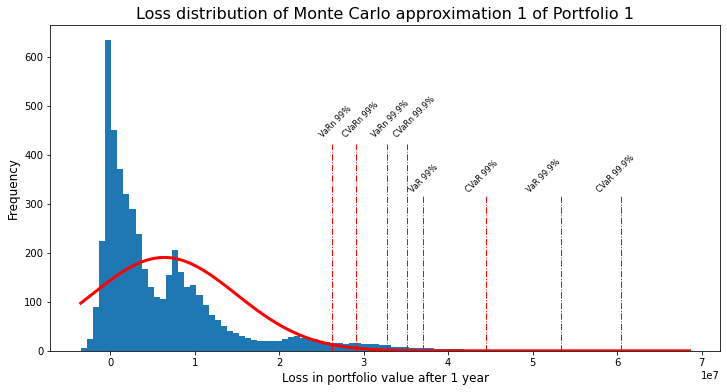

In [8]:
# Monte Carlo approximation 1
mean_VaRinMC1 = np.zeros((2,2))
mean_VaRinMC1[0,0] = np.mean(VaRinMC1[0,0]) # port1 99%
mean_VaRinMC1[0,1] = np.mean(VaRinMC1[0,1]) # port1 99.9%
mean_VaRinMC1[1,0] = np.mean(VaRinMC1[1,0]) # port2 99%
mean_VaRinMC1[1,1] = np.mean(VaRinMC1[1,1]) # port2 99.9%
mean_CVaRinMC1 = np.zeros((2,2))
mean_CVaRinMC1[0,0] = np.mean(CVaRinMC1[0,0]) # port1 99%
mean_CVaRinMC1[0,1] = np.mean(CVaRinMC1[0,1]) # port1 99.9
mean_CVaRinMC1[1,0] = np.mean(CVaRinMC1[1,0]) # port2 99%
mean_CVaRinMC1[1,1] = np.mean(CVaRinMC1[1,1]) # port2 99.9%
# Normal distribution
mean_VaRinN1 = np.zeros((2,2))
mean_VaRinN1[0,0] = np.mean(VaRinN1[0,0]) # port1 99%
mean_VaRinN1[0,1] = np.mean(VaRinN1[0,1]) # port1 99.9%
mean_VaRinN1[1,0] = np.mean(VaRinN1[1,0]) # port2 99%
mean_VaRinN1[1,1] = np.mean(VaRinN1[1,1]) # port2 99.9%
mean_CVaRinN1 = np.zeros((2,2))
mean_CVaRinN1[0,0] = np.mean(CVaRinN1[0,0]) # port1 99%
mean_CVaRinN1[0,1] = np.mean(CVaRinN1[0,1]) # port1 99.9%
mean_CVaRinN1[1,0] = np.mean(CVaRinN1[1,0]) # port2 99%
mean_CVaRinN1[1,1] = np.mean(CVaRinN1[1,1]) # port2 99.9%

# Figure 1 
fig = plt.figure(figsize=(12,6))
frequencyCounts, binLocations, patches = plt.hist(mean_portf1_loss_inMC1, bins=100)
normf = (1 / (np.std(mean_portf1_loss_inMC1)*math.sqrt(2*math.pi))) * np.exp(-0.5 * ((binLocations - np.mean(mean_portf1_loss_inMC1))/np.std(mean_portf1_loss_inMC1))**2)
normf = normf * sum(frequencyCounts) / sum(normf)
plt.plot(binLocations, normf, color='r', linewidth = 3.0)
plt.plot([mean_VaRinMC1[0,0],mean_VaRinMC1[0,0]],[0,max(frequencyCounts)/2],color='r',linewidth=1,linestyle='-.')
plt.text(0.95*mean_VaRinMC1[0,0], max(frequencyCounts)/1.95, 'VaR 99%',fontsize=8, rotation=45)
plt.plot([mean_VaRinMC1[0,1],mean_VaRinMC1[0,1]],[0,max(frequencyCounts)/2],color='r',linewidth=1,linestyle='-.')
plt.text(0.92*mean_VaRinMC1[0,1], max(frequencyCounts)/1.95, 'VaR 99.9%',fontsize=8, rotation=45)
plt.plot([mean_CVaRinMC1[0,0],mean_CVaRinMC1[0,0]],[0,max(frequencyCounts)/2],color='r',linewidth=1,linestyle='-.')
plt.text(0.94*mean_CVaRinMC1[0,0], max(frequencyCounts)/1.95, 'CVaR 99%',fontsize=8, rotation=45)
plt.plot([mean_CVaRinMC1[0,1],mean_CVaRinMC1[0,1]],[0,max(frequencyCounts)/2],color='r',linewidth=1,linestyle='-.')
plt.text(0.95*mean_CVaRinMC1[0,1], max(frequencyCounts)/1.95, 'CVaR 99.9%',fontsize=8, rotation=45)

plt.plot([mean_VaRinN1[0,0],mean_VaRinN1[0,0]],[0,max(frequencyCounts)/1.5],color='r',linewidth=1,linestyle='-.')
plt.text(0.94*mean_VaRinN1[0,0], max(frequencyCounts)/1.45, 'VaRn 99%',fontsize=8, rotation=45)
plt.plot([mean_VaRinN1[0,1],mean_VaRinN1[0,1]],[0,max(frequencyCounts)/1.5],color='r',linewidth=1,linestyle='-.')
plt.text(0.94*mean_VaRinN1[0,1], max(frequencyCounts)/1.45, 'VaRn 99.9%',fontsize=8, rotation=45)
plt.plot([mean_CVaRinN1[0,0],mean_CVaRinN1[0,0]],[0,max(frequencyCounts)/1.5],color='r',linewidth=1,linestyle='-.')
plt.text(0.94*mean_CVaRinN1[0,0], max(frequencyCounts)/1.45, 'CVaRn 99%',fontsize=8, rotation=45)
plt.plot([mean_CVaRinN1[0,1],mean_CVaRinN1[0,1]],[0,max(frequencyCounts)/1.5],color='r',linewidth=1,linestyle='-.')
plt.text(0.95*mean_CVaRinN1[0,1], max(frequencyCounts)/1.45, 'CVaRn 99.9%',fontsize=8, rotation=45)
plt.xlabel('Loss in portfolio value after 1 year',fontsize=12)
plt.ylabel('Frequency',fontsize=12)
plt.title('Loss distribution of Monte Carlo approximation 1 of Portfolio 1',fontsize=16)
plt.show()

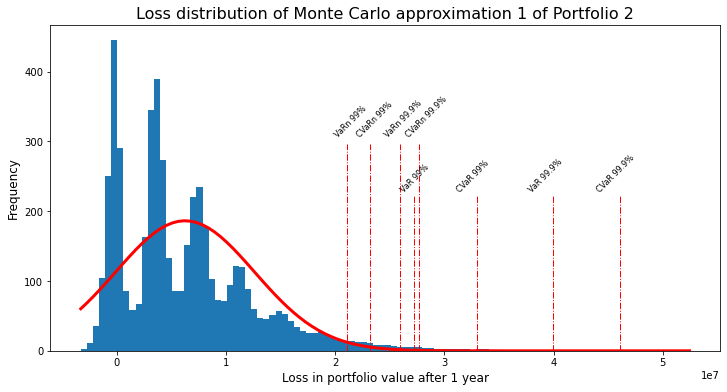

In [9]:
# Figure 2 
fig = plt.figure(figsize=(12,6))
frequencyCounts, binLocations, patches = plt.hist(mean_portf2_loss_inMC1, bins=100)
normf = (1 / (np.std(mean_portf2_loss_inMC1)*math.sqrt(2*math.pi))) * np.exp(-0.5 * ((binLocations - np.mean(mean_portf2_loss_inMC1))/np.std(mean_portf2_loss_inMC1))**2)
normf = normf * sum(frequencyCounts) / sum(normf)
plt.plot(binLocations, normf, color='r', linewidth = 3.0)
plt.plot([mean_VaRinMC1[1,0],mean_VaRinMC1[1,0]],[0,max(frequencyCounts)/2],color='r',linewidth=1,linestyle='-.')
plt.text(0.95*mean_VaRinMC1[1,0], max(frequencyCounts)/1.95, 'VaR 99%',fontsize=8, rotation=45)
plt.plot([mean_VaRinMC1[1,1],mean_VaRinMC1[1,1]],[0,max(frequencyCounts)/2],color='r',linewidth=1,linestyle='-.')
plt.text(0.94*mean_VaRinMC1[1,1], max(frequencyCounts)/1.95, 'VaR 99.9%',fontsize=8, rotation=45)
plt.plot([mean_CVaRinMC1[1,0],mean_CVaRinMC1[1,0]],[0,max(frequencyCounts)/2],color='r',linewidth=1,linestyle='-.')
plt.text(0.94*mean_CVaRinMC1[1,0], max(frequencyCounts)/1.95, 'CVaR 99%',fontsize=8, rotation=45)
plt.plot([mean_CVaRinMC1[1,1],mean_CVaRinMC1[1,1]],[0,max(frequencyCounts)/2],color='r',linewidth=1,linestyle='-.')
plt.text(0.95*mean_CVaRinMC1[1,1], max(frequencyCounts)/1.95, 'CVaR 99.9%',fontsize=8, rotation=45)

plt.plot([mean_VaRinN1[1,0],mean_VaRinN1[1,0]],[0,max(frequencyCounts)/1.5],color='r',linewidth=1,linestyle='-.')
plt.text(0.94*mean_VaRinN1[1,0], max(frequencyCounts)/1.45, 'VaRn 99%',fontsize=8, rotation=45)
plt.plot([mean_VaRinN1[1,1],mean_VaRinN1[1,1]],[0,max(frequencyCounts)/1.5],color='r',linewidth=1,linestyle='-.')
plt.text(0.94*mean_VaRinN1[1,1], max(frequencyCounts)/1.45, 'VaRn 99.9%',fontsize=8, rotation=45)
plt.plot([mean_CVaRinN1[1,0],mean_CVaRinN1[1,0]],[0,max(frequencyCounts)/1.5],color='r',linewidth=1,linestyle='-.')
plt.text(0.94*mean_CVaRinN1[1,0], max(frequencyCounts)/1.45, 'CVaRn 99%',fontsize=8, rotation=45)
plt.plot([mean_CVaRinN1[1,1],mean_CVaRinN1[1,1]],[0,max(frequencyCounts)/1.5],color='r',linewidth=1,linestyle='-.')
plt.text(0.95*mean_CVaRinN1[1,1], max(frequencyCounts)/1.45, 'CVaRn 99.9%',fontsize=8, rotation=45)
plt.xlabel('Loss in portfolio value after 1 year',fontsize=12)
plt.ylabel('Frequency',fontsize=12)
plt.title('Loss distribution of Monte Carlo approximation 1 of Portfolio 2',fontsize=16)
plt.show()

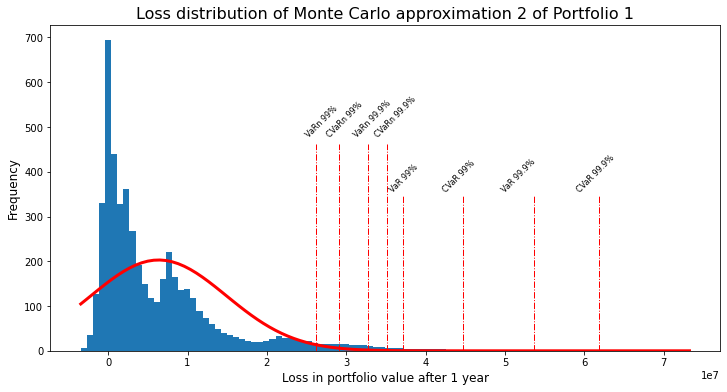

In [10]:
# Monte Carlo approximation 2
mean_VaRinMC2 = np.zeros((2,2))
mean_VaRinMC2[0,0] = np.mean(VaRinMC2[0,0]) # port1 99%
mean_VaRinMC2[0,1] = np.mean(VaRinMC2[0,1]) # port1 99.9%
mean_VaRinMC2[1,0] = np.mean(VaRinMC2[1,0]) # port2 99%
mean_VaRinMC2[1,1] = np.mean(VaRinMC2[1,1]) # port2 99.9%
mean_CVaRinMC2 = np.zeros((2,2))
mean_CVaRinMC2[0,0] = np.mean(CVaRinMC2[0,0]) # port1 99%
mean_CVaRinMC2[0,1] = np.mean(CVaRinMC2[0,1]) # port1 99.9
mean_CVaRinMC2[1,0] = np.mean(CVaRinMC2[1,0]) # port2 99%
mean_CVaRinMC2[1,1] = np.mean(CVaRinMC2[1,1]) # port2 99.9%
# Normal distribution
mean_VaRinN2 = np.zeros((2,2))
mean_VaRinN2[0,0] = np.mean(VaRinN2[0,0]) # port1 99%
mean_VaRinN2[0,1] = np.mean(VaRinN2[0,1]) # port1 99.9%
mean_VaRinN2[1,0] = np.mean(VaRinN2[1,0]) # port2 99%
mean_VaRinN2[1,1] = np.mean(VaRinN2[1,1]) # port2 99.9%
mean_CVaRinN2 = np.zeros((2,2))
mean_CVaRinN2[0,0] = np.mean(CVaRinN2[0,0]) # port1 99%
mean_CVaRinN2[0,1] = np.mean(CVaRinN2[0,1]) # port1 99.9%
mean_CVaRinN2[1,0] = np.mean(CVaRinN2[1,0]) # port2 99%
mean_CVaRinN2[1,1] = np.mean(CVaRinN2[1,1]) # port2 99.9%

# Figure 1 
fig = plt.figure(figsize=(12,6))
frequencyCounts, binLocations, patches = plt.hist(mean_portf1_loss_inMC2, bins=100)
normf = (1 / (np.std(mean_portf1_loss_inMC2)*math.sqrt(2*math.pi))) * np.exp(-0.5 * ((binLocations - np.mean(mean_portf1_loss_inMC2))/np.std(mean_portf1_loss_inMC2))**2)
normf = normf * sum(frequencyCounts) / sum(normf)
plt.plot(binLocations, normf, color='r', linewidth = 3.0)
plt.plot([mean_VaRinMC2[0,0],mean_VaRinMC2[0,0]],[0,max(frequencyCounts)/2],color='r',linewidth=1,linestyle='-.')
plt.text(0.95*mean_VaRinMC2[0,0], max(frequencyCounts)/1.95, 'VaR 99%',fontsize=8, rotation=45)
plt.plot([mean_VaRinMC2[0,1],mean_VaRinMC2[0,1]],[0,max(frequencyCounts)/2],color='r',linewidth=1,linestyle='-.')
plt.text(0.92*mean_VaRinMC2[0,1], max(frequencyCounts)/1.95, 'VaR 99.9%',fontsize=8, rotation=45)
plt.plot([mean_CVaRinMC2[0,0],mean_CVaRinMC2[0,0]],[0,max(frequencyCounts)/2],color='r',linewidth=1,linestyle='-.')
plt.text(0.94*mean_CVaRinMC2[0,0], max(frequencyCounts)/1.95, 'CVaR 99%',fontsize=8, rotation=45)
plt.plot([mean_CVaRinMC2[0,1],mean_CVaRinMC2[0,1]],[0,max(frequencyCounts)/2],color='r',linewidth=1,linestyle='-.')
plt.text(0.95*mean_CVaRinMC2[0,1], max(frequencyCounts)/1.95, 'CVaR 99.9%',fontsize=8, rotation=45)

plt.plot([mean_VaRinN2[0,0],mean_VaRinN2[0,0]],[0,max(frequencyCounts)/1.5],color='r',linewidth=1,linestyle='-.')
plt.text(0.94*mean_VaRinN2[0,0], max(frequencyCounts)/1.45, 'VaRn 99%',fontsize=8, rotation=45)
plt.plot([mean_VaRinN2[0,1],mean_VaRinN2[0,1]],[0,max(frequencyCounts)/1.5],color='r',linewidth=1,linestyle='-.')
plt.text(0.94*mean_VaRinN2[0,1], max(frequencyCounts)/1.45, 'VaRn 99.9%',fontsize=8, rotation=45)
plt.plot([mean_CVaRinN2[0,0],mean_CVaRinN2[0,0]],[0,max(frequencyCounts)/1.5],color='r',linewidth=1,linestyle='-.')
plt.text(0.94*mean_CVaRinN2[0,0], max(frequencyCounts)/1.45, 'CVaRn 99%',fontsize=8, rotation=45)
plt.plot([mean_CVaRinN2[0,1],mean_CVaRinN2[0,1]],[0,max(frequencyCounts)/1.5],color='r',linewidth=1,linestyle='-.')
plt.text(0.95*mean_CVaRinN2[0,1], max(frequencyCounts)/1.45, 'CVaRn 99.9%',fontsize=8, rotation=45)
plt.xlabel('Loss in portfolio value after 1 year',fontsize=12)
plt.ylabel('Frequency',fontsize=12)
plt.title('Loss distribution of Monte Carlo approximation 2 of Portfolio 1',fontsize=16)
plt.show()

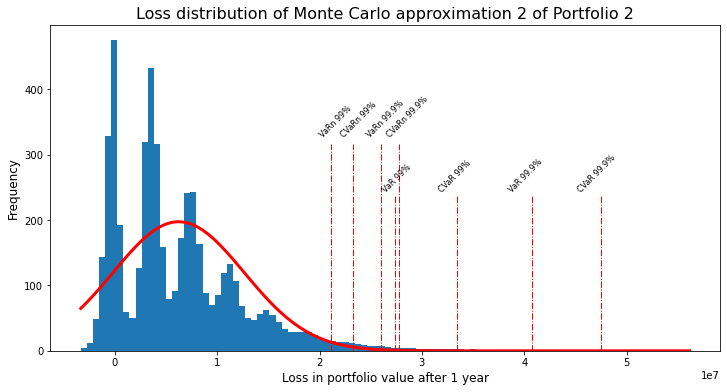

In [11]:
# Figure 2 
fig = plt.figure(figsize=(12,6))
frequencyCounts, binLocations, patches = plt.hist(mean_portf2_loss_inMC2, bins=100)
normf = (1 / (np.std(mean_portf2_loss_inMC2)*math.sqrt(2*math.pi))) * np.exp(-0.5 * ((binLocations - np.mean(mean_portf2_loss_inMC2))/np.std(mean_portf2_loss_inMC2))**2)
normf = normf * sum(frequencyCounts) / sum(normf)
plt.plot(binLocations, normf, color='r', linewidth = 3.0)
plt.plot([mean_VaRinMC2[1,0],mean_VaRinMC2[1,0]],[0,max(frequencyCounts)/2],color='r',linewidth=1,linestyle='-.')
plt.text(0.95*mean_VaRinMC2[1,0], max(frequencyCounts)/1.95, 'VaR 99%',fontsize=8, rotation=45)
plt.plot([mean_VaRinMC2[1,1],mean_VaRinMC2[1,1]],[0,max(frequencyCounts)/2],color='r',linewidth=1,linestyle='-.')
plt.text(0.94*mean_VaRinMC2[1,1], max(frequencyCounts)/1.95, 'VaR 99.9%',fontsize=8, rotation=45)
plt.plot([mean_CVaRinMC2[1,0],mean_CVaRinMC2[1,0]],[0,max(frequencyCounts)/2],color='r',linewidth=1,linestyle='-.')
plt.text(0.94*mean_CVaRinMC2[1,0], max(frequencyCounts)/1.95, 'CVaR 99%',fontsize=8, rotation=45)
plt.plot([mean_CVaRinMC2[1,1],mean_CVaRinMC2[1,1]],[0,max(frequencyCounts)/2],color='r',linewidth=1,linestyle='-.')
plt.text(0.95*mean_CVaRinMC2[1,1], max(frequencyCounts)/1.95, 'CVaR 99.9%',fontsize=8, rotation=45)

plt.plot([mean_VaRinN2[1,0],mean_VaRinN2[1,0]],[0,max(frequencyCounts)/1.5],color='r',linewidth=1,linestyle='-.')
plt.text(0.94*mean_VaRinN2[1,0], max(frequencyCounts)/1.45, 'VaRn 99%',fontsize=8, rotation=45)
plt.plot([mean_VaRinN2[1,1],mean_VaRinN2[1,1]],[0,max(frequencyCounts)/1.5],color='r',linewidth=1,linestyle='-.')
plt.text(0.94*mean_VaRinN2[1,1], max(frequencyCounts)/1.45, 'VaRn 99.9%',fontsize=8, rotation=45)
plt.plot([mean_CVaRinN2[1,0],mean_CVaRinN2[1,0]],[0,max(frequencyCounts)/1.5],color='r',linewidth=1,linestyle='-.')
plt.text(0.94*mean_CVaRinN2[1,0], max(frequencyCounts)/1.45, 'CVaRn 99%',fontsize=8, rotation=45)
plt.plot([mean_CVaRinN2[1,1],mean_CVaRinN2[1,1]],[0,max(frequencyCounts)/1.5],color='r',linewidth=1,linestyle='-.')
plt.text(0.95*mean_CVaRinN2[1,1], max(frequencyCounts)/1.45, 'CVaRn 99.9%',fontsize=8, rotation=45)
plt.xlabel('Loss in portfolio value after 1 year',fontsize=12)
plt.ylabel('Frequency',fontsize=12)
plt.title('Loss distribution of Monte Carlo approximation 2 of Portfolio 2',fontsize=16)
plt.show()